In [4]:
function spike(t,a,e,tcrit)
   return 1.0/(((t-tcrit)^2.0+1)^(e))*a
end
function detect(t,a,e,tcrit)
    if e > 7000.0 && a > 0.7
        return (spike(t,a,e,tcrit) > 0.3*a)
   else
        return false
    end
    
end

SPEC = [
    [1.0,200.0,0.8],
    [0.1,500.0,0.25],
    [0.1,8000.0,0.1],
    [1.0,8000.0,0.4],
    [1.0,8000.0,0.6]
]



5-element Array{Array{Float64,1},1}:
 [1.0, 200.0, 0.8] 
 [0.1, 500.0, 0.25]
 [0.1, 8000.0, 0.1]
 [1.0, 8000.0, 0.4]
 [1.0, 8000.0, 0.6]

In [5]:
function eval_func(t,is_x)
    result = 0.0
    for row in SPEC
        ampl,expo,tcrit = row
        if is_x
            value = spike(t,ampl,expo,tcrit)
        else
            value = detect(t,ampl,expo,tcrit)
        end
        result += value
    end
    return result
end
    


eval_func (generic function with 1 method)

In [7]:
tspan = tmax = 1.0
datasize = 1000
t = range(0.0,tmax,length=datasize);
display(size(t))
s = map((q) -> eval_func(q,true), t);
a = map((q) -> eval_func(q,false), t);

(1000,)

In [8]:
using Plots

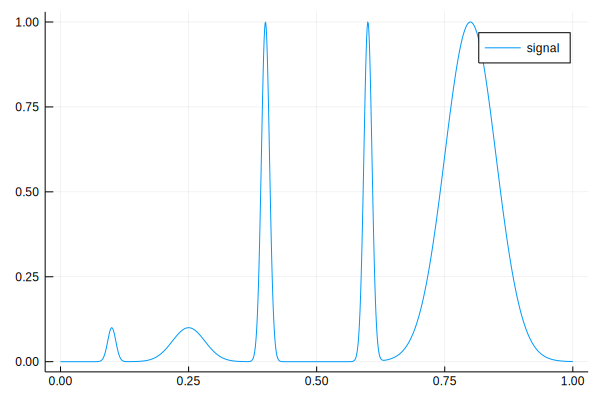

In [9]:
plot(t,s,label="signal")

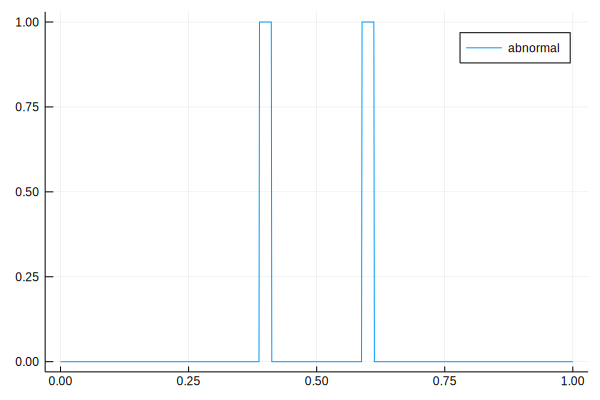

In [10]:
plot(t,a,label="abnormal")

In [11]:
using Flux, DiffEqFlux

In [12]:
using DifferentialEquations

In [53]:
using Formatting: printfmt

In [92]:
nnet = Chain(Dense(2,50,tanh), Dense(50,2))

Chain(Dense(2, 50, tanh), Dense(50, 2))

In [121]:
x = [0.0,0.0]
function n_ode(u)
 #ti,xi = u
 #si = eval_func(ti,true)
 result = neural_ode(nnet,u,tspan,Tsit5(),saveat=t,reltol=1e-7,abstol=1e-9)
 return result
end

function predict_n_ode(ts)
  pred_v = n_ode([ts,eval_func(ts,true)])
  return pred_v
end
function error_n_ode(ts)
   err = sum(predict_n_ode(ts)) .- eval_func(ts,false)
   return err
end
function loss_n_ode(ts)
    display(size(ts))
    loss = sum(broadcast(abs,error_n_ode(ts)))
    printfmt("loss $loss", loss)
    return loss
end

loss_n_ode (generic function with 1 method)

In [122]:
cb = function () #callback function to observe training
  # plot current prediction against data
  pred = map(ti -> Flux.data(predict_n_ode(ti))[1], t)
  gtruth = map(ti -> eval_func(ti,false), t)
  plt = plot(t,gtruth,label="data")
  plot!(plt,t,pred,label="prediction")
  display(plot(plt))
end

#351 (generic function with 1 method)

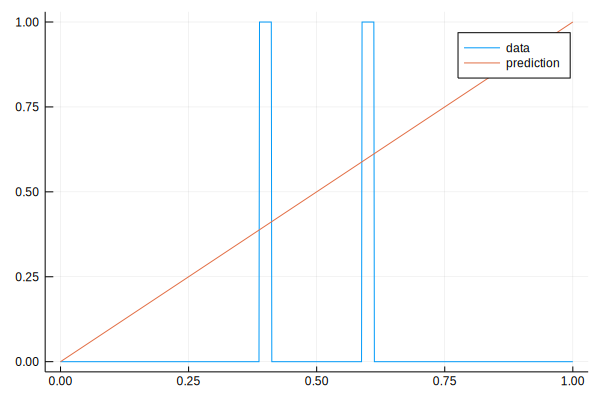

"training"

()

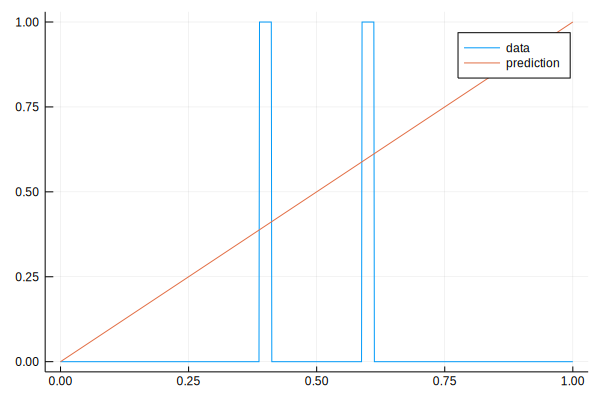

()

loss 1.561043074466431e-11 (tracked)loss 755.3382104967595 (tracked)

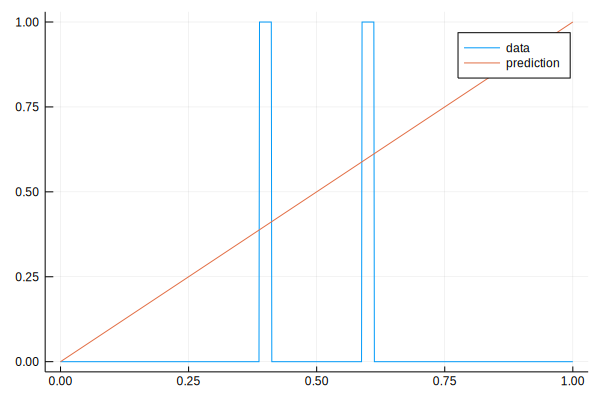

()

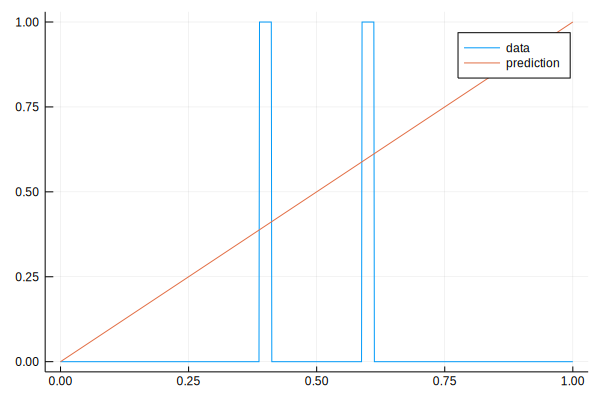

()

loss 521.3092549161969 (tracked)loss 122.1232145780182 (tracked)

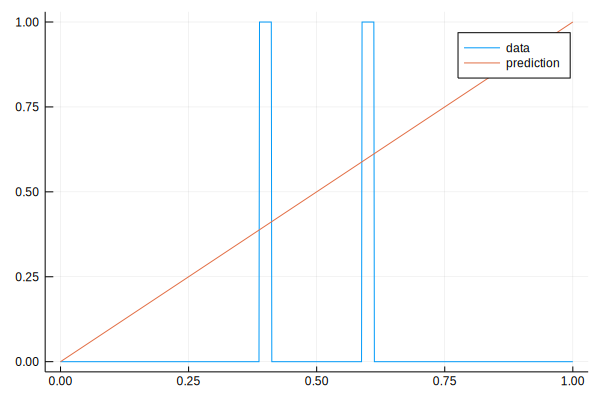

()

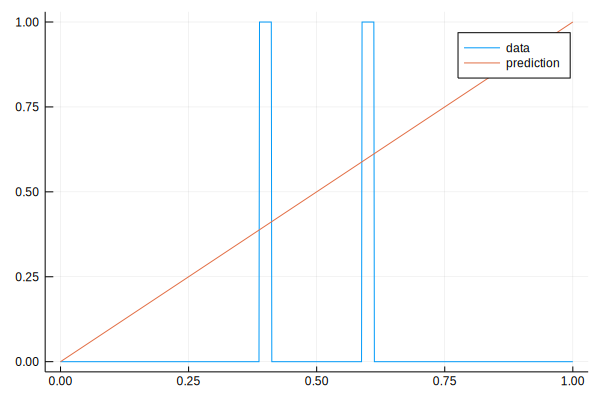

()

loss 30.946988153993836 (tracked)loss 331.22575119560685 (tracked)

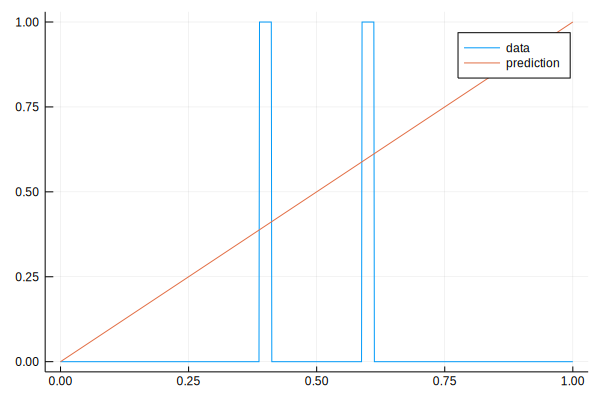

()

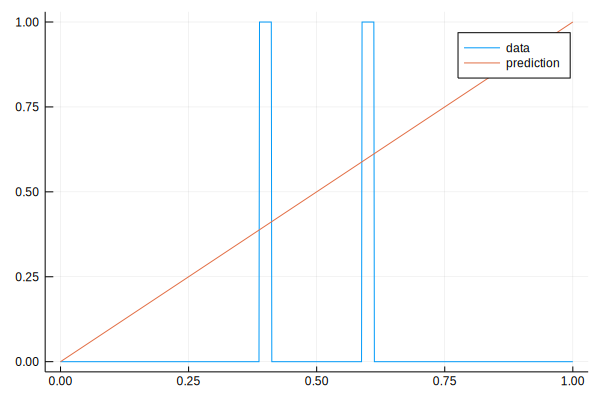

()

loss 394.17852833000256 (tracked)loss 329.03453154979826 (tracked)

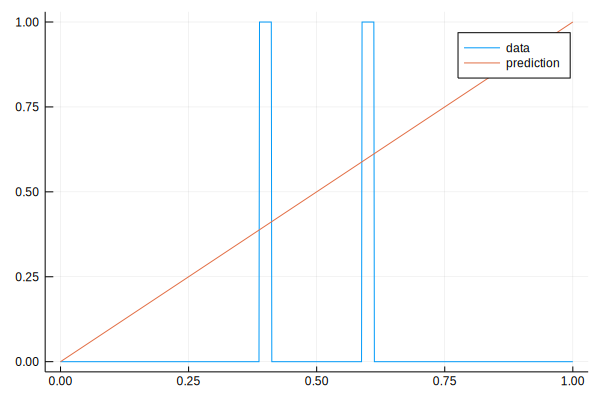

()

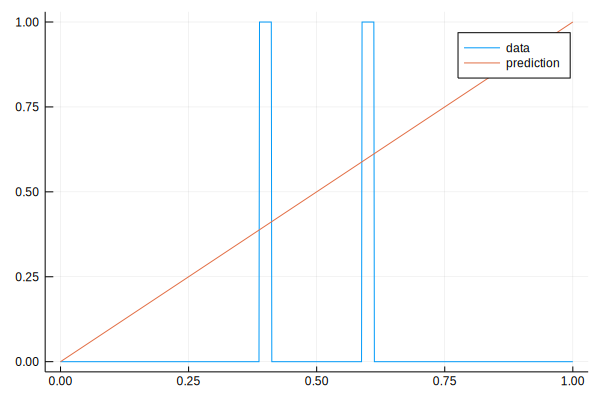

()

loss 166.9703186362412 (tracked)loss 129.7387747807793 (tracked)

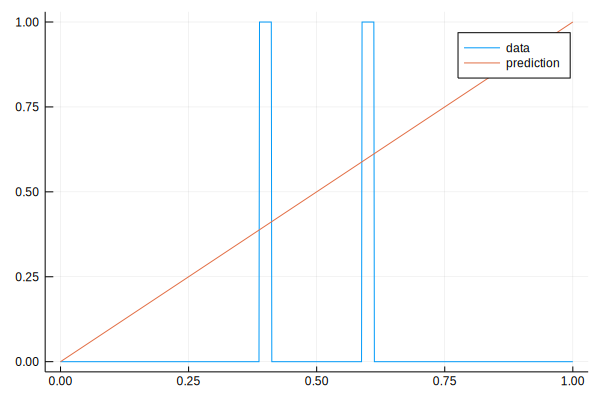

()

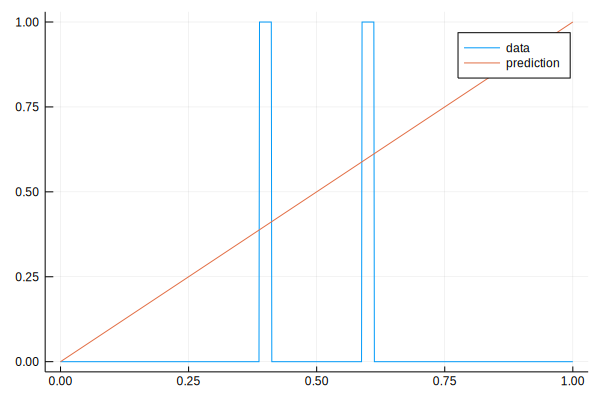

()

loss 189.60067584377452 (tracked)loss 70.76805650531051 (tracked)

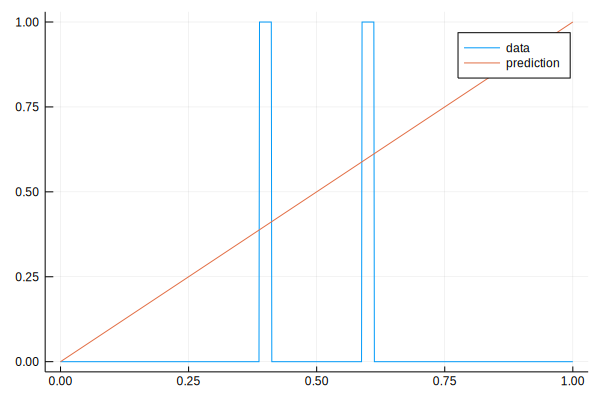

()

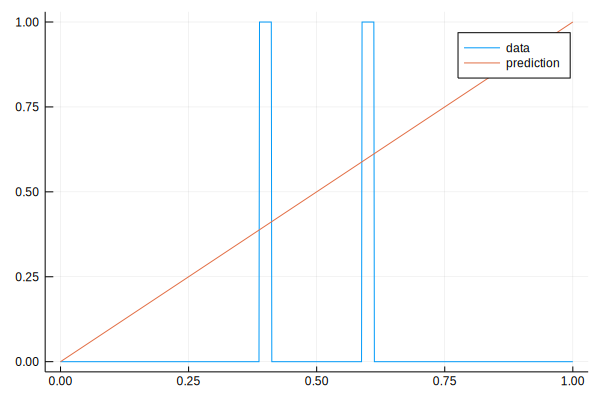

()

loss 89.88722759267425 (tracked)loss 140.01137984737062 (tracked)

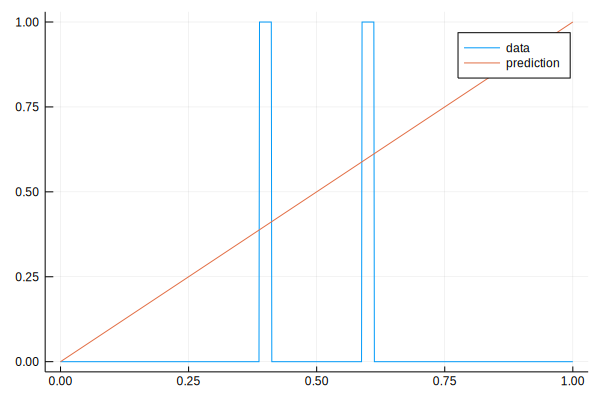

()

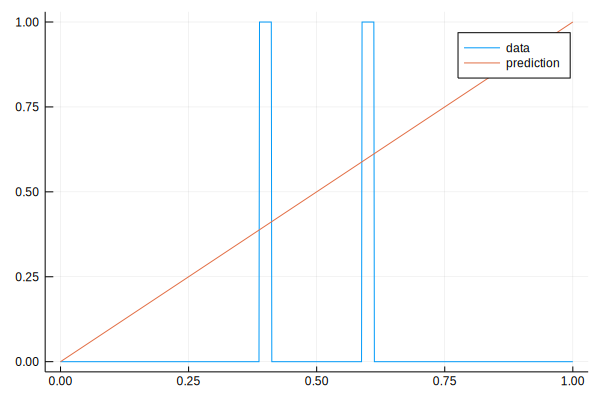

()

loss 136.72501297614903 (tracked)loss 99.44205518559764 (tracked)

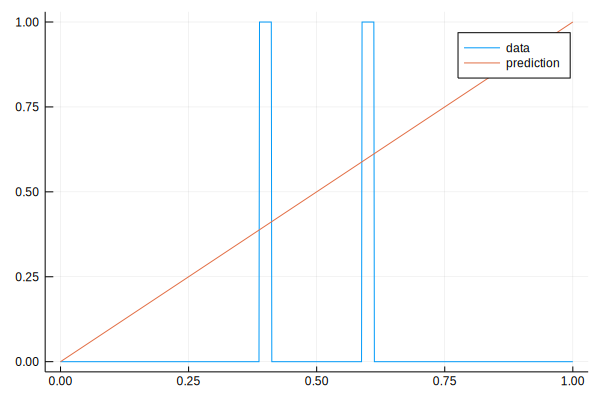

()

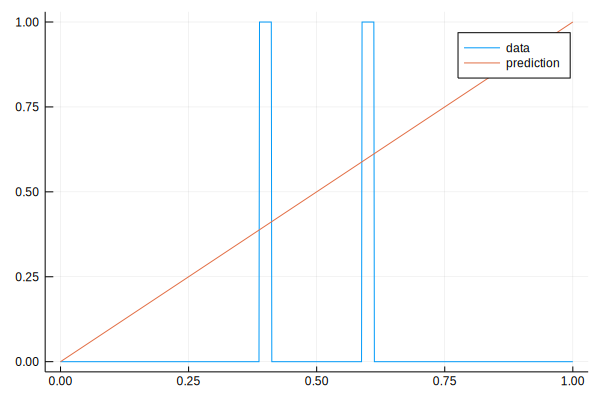

()

loss 34.98678817023431 (tracked)loss 56.49715134522242 (tracked)

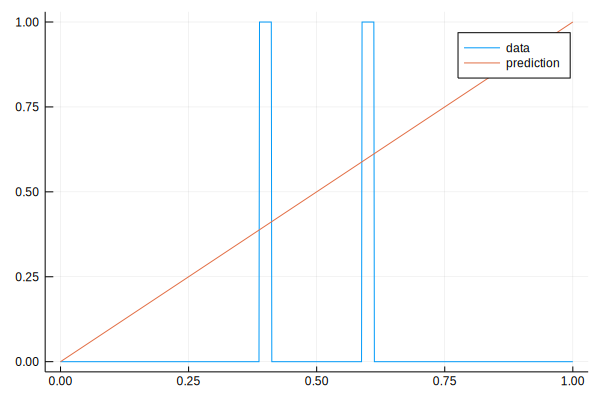

()

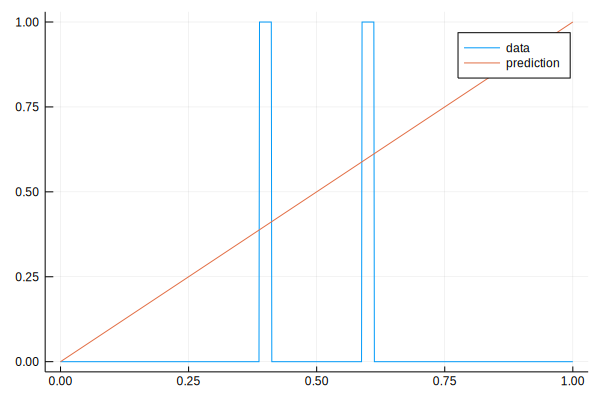

()

loss 97.81578217681238 (tracked)loss 94.89852680516286 (tracked)

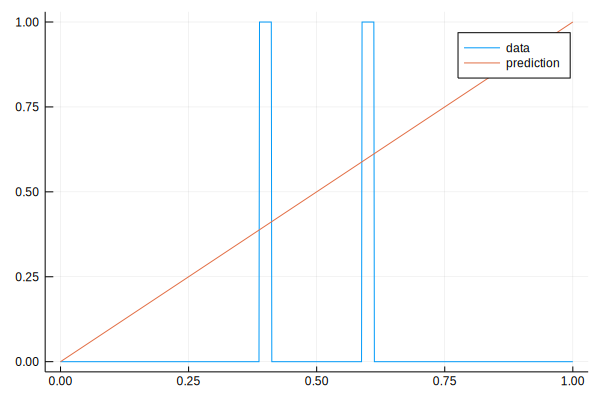

()

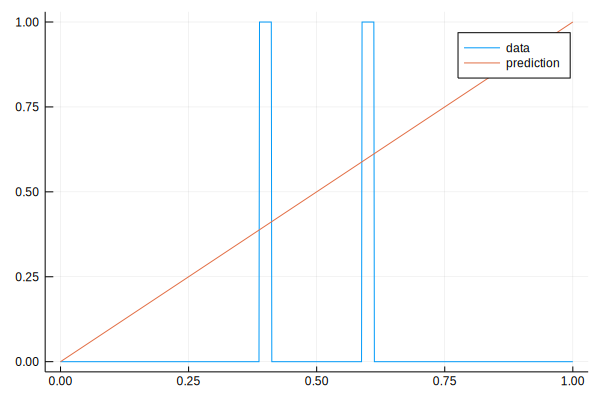

()

loss 60.544252438026234 (tracked)loss 7.925733710973496 (tracked)

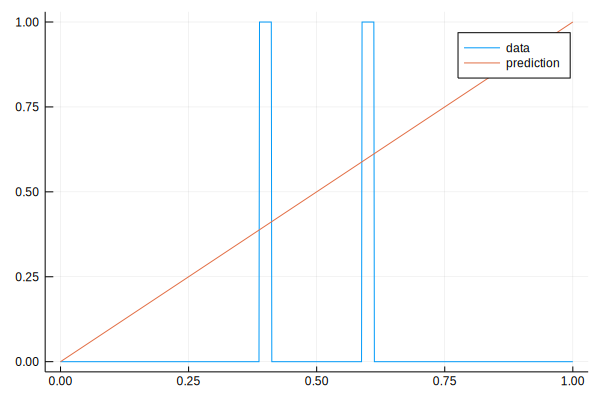

()

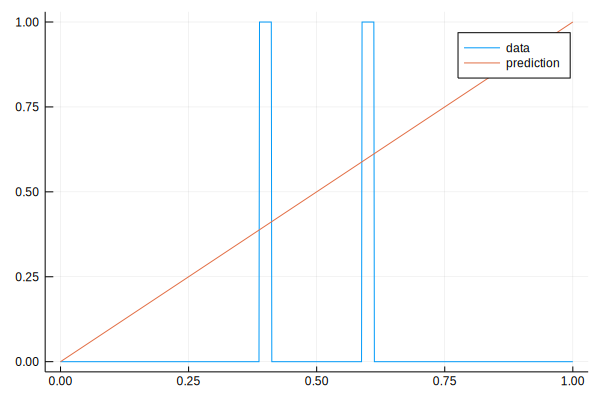

()

loss 53.10448121263195 (tracked)loss 84.06208592263788 (tracked)

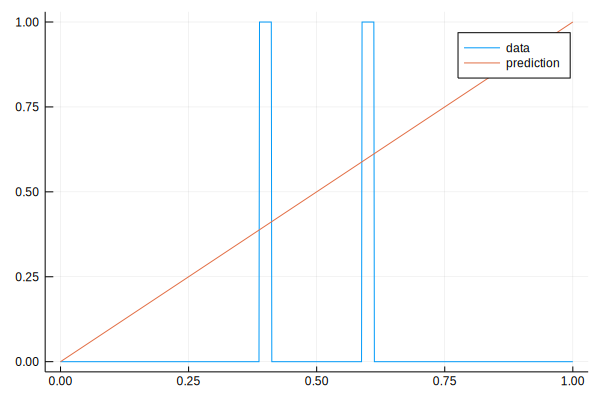

()

loss 94.45704452247492 (tracked)

InterruptException: InterruptException:

In [123]:
opt = ADAM(0.1)
#data = Iterators.repeated(t, 1000)
data = t
cb()
display("training")
ps = Flux.params(nnet)
Flux.train!(loss_n_ode, ps, s, opt, cb=cb)